In [1]:
DEBUG = False
N_DEBUG = 10
USE_CACHE = True

In [2]:
import pandas as pd
import numpy as np
import transformers
import torch
import re
from tqdm import tqdm
import sklearn
# import spacy
# nlp = spacy.load("en_core_web_sm")

In [3]:
test = pd.read_pickle("./dataset_test.pkl")


documents = test["answer"]
gold_labels = test["author"] == "human_answers" # convention: 0: machine, 1: human, see detector.py

if DEBUG and N_DEBUG > 0:
    documents = documents[0:N_DEBUG]
    gold_labels = gold_labels[0:N_DEBUG]



from detector_radford import DetectorRadford
from detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
detector_classes = [DetectorRadford, DetectorGuo]

from explainer_wrappers import LIME_Explainer, SHAP_Explainer, Random_Explainer, Anchor_Explainer
explainer_classes = [Anchor_Explainer, LIME_Explainer, SHAP_Explainer]

In [4]:
from IPython.core.display import display, HTML

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [5]:
from abc import ABC, abstractmethod
class Experiment(ABC):
    @abstractmethod 
    def __init__(self, explainer, document, gt):
        self.document = document
        self.gt = gt
        self.explainer = explainer
        self.fi_scores_machine  = self.explainer.get_fi_scores(document, fill=True)[0]
        self.fi_scores_human = self.explainer.get_fi_scores(document, fill=True)[1]
    @property
    @abstractmethod
    def modified_document(self):
        pass
    # as in Arras et al. 2016: "The target class is the true document class,[...]"
    def get_fi_scores_target(self):
        if self.gt:
            return self.fi_scores_human
        else:
            return self.fi_scores_machine
    def remove_features(self, id_fi_tuples_list, mask=True):
        tokenized_modified_document = self.explainer.tokenize(self.document)

        # two asserts to verify that approach is valid
       # print("r",expself.explainerlainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)))
       # print("o", self.document)
        # this fails: 
        # assert self.explainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)) == self.document, "Merging strategy faulty"
        # see self.explainer.LIME_Explainer.untokenize
       
        ### assert right words are removed
        top_words = [word for word, fi in self.explainer.as_list(self.explainer.get_explanation_cached(self.document), label=self.gt) if fi > 0]
        for a, b in zip(tokenized_modified_document, self.explainer.tokenize(self.document)):
            if a == self.explainer.detector.get_pad_token():
                assert b in top_words, "Masking strategy faulty"
        ###
       
        ids_tokens_to_remove = []
        # don't remove anything if there are no best/worst features (e.g. only positive or only negative fi scores)
        if len(id_fi_tuples_list):
            ids_tokens_to_remove, _ = zip(*id_fi_tuples_list) 
        # replace with pad token (all detectors support partial input)
        if mask:
            for t in ids_tokens_to_remove:
                tokenized_modified_document[t] = self.explainer.detector.get_pad_token()
        else:
            tokenized_modified_document = [t for i, t in enumerate(tokenized_modified_document) if i not in ids_tokens_to_remove]
        return self.explainer.untokenize(tokenized_modified_document)

In [6]:
class Experiment_Delete_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        if self.n == 0:
            return self.document
        highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[0:self.n]
        # remove 0 scores if !include_zero_scores
        highest_fi_scores_target = [(idx, fi) for idx,fi in highest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        if len(highest_fi_scores_target) < self.n and (not self.include_zero_scores):
            return None
        return self.remove_features(highest_fi_scores_target, mask=self.mask)


In [7]:
class Experiment_Delete_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[0:self.n]
        # remove 0 scores if !include_zero_scores
        lowest_fi_scores_target = [(idx, fi) for idx,fi in lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        if len(lowest_fi_scores_target) < self.n and (not self.include_zero_scores):
            return None
        return self.remove_features(lowest_fi_scores_target, mask=self.mask)


In [8]:
class Experiment_Delete_all_except_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        all_but_highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[self.n:]
        all_but_highest_fi_scores_target = [(idx, fi) for idx,fi in all_but_highest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_highest_fi_scores_target, mask=self.mask)

In [9]:
class Experiment_Delete_all_except_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):

        all_but_lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[self.n:]
        all_but_lowest_fi_scores_target = [(idx, fi) for idx,fi in all_but_lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_lowest_fi_scores_target, mask=self.mask)

In [10]:
prediction_cache = {}
def prediction_cached(detector, document):
    id = (detector.__class__.__name__,document)
    if id not in prediction_cache:
        prediction_cache[id] = detector.predict_proba([document])[0]
    return prediction_cache[id]


In [11]:
def get_results_row(document, gt,  explainer, experiment_class, detector, n, mask):
    
    experiment = experiment_class(explainer, document, gt, n=n, mask=mask)
    if experiment.modified_document is None: # modified_document is None when len(fi_scores) < n. skip to speed up calculation
        return [    explainer.__class__.__name__, 
                    explainer.detector.__class__.__name__, 
                    n,
                    None,
                    None,
                    None,
                    None,
                    None,
                    None,
                    None]
    p_machine_original, p_human_original  = prediction_cached(detector, experiment.document)
    y_original = p_human_original >= p_machine_original

    p_machine_modified = None
    p_human_modified = None

    p_machine_modified, p_human_modified = prediction_cached(detector, experiment.modified_document)
    y_modified = p_human_modified >= p_machine_modified
    return [
                    explainer.__class__.__name__, 
                    explainer.detector.__class__.__name__, 
                    n,
                    p_machine_original,
                    p_human_original,
                    y_original,
                    p_machine_modified,
                    p_human_modified,
                    y_modified,
                    gt]

In [12]:
def run_experiment(experiment_class, detector, n=10, mask=True):
    results = []
    columns=["Explainer", "Detector", "n", "p_machine_original", "p_human_original", "y_original", "p_machine_modified", "p_human_modified", "y_modified", "gt"]
    
    for explainer_class in explainer_classes:
        explainer = explainer_class(detector)
        if isinstance(explainer, LIME_Explainer) and n > explainer.num_features:
            print("skip lime",n, explainer.num_features)
            continue
        if isinstance(explainer, Anchor_Explainer) and isinstance(detector, DetectorDetectGPT):
            print("skip anchor detectgpt",n, explainer.num_features)
            continue
        for document, gt in zip(documents, gold_labels):
            results.append(get_results_row(document, gt, explainer, experiment_class, detector, n, mask))

    # random baseline (with new seeds at each run)
    for i in range(0,10):
        random_explainer = Random_Explainer(detector, seed=42-i)
        for document, gt in zip(documents, gold_labels):
            results_row = get_results_row(document, gt, random_explainer, experiment_class, detector, n, mask)
            results_row[0] = "Random Run "+str(i)
            results.append(results_row)

    df = pd.DataFrame(results, columns=columns)

    df["p_target_original"] = df.apply(lambda x: x["p_human_original"] if x["gt"] else x["p_machine_original"], axis=1)
    df["p_target_modified"] = df.apply(lambda x: x["p_human_modified"] if x["gt"] else x["p_machine_modified"], axis=1)    
    df["drop_target"] = df["p_target_original"] - df["p_target_modified"] 

    

    return df

In [13]:
import matplotlib.pyplot as plt

## Plot like in Arras et al.

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
def get_acc_by_initial_prediction_right_wrong(df, n, mask):
    accs = []
    for explainer_name, group in df.groupby("Explainer"):
        group_initial_right = group[group["y_original"] == group["gt"]]
        group_initial_wrong = group[group["y_original"] != group["gt"]]
        # display(group_initial_right)
        # display(group_initial_wrong)
        acc_initial_right = accuracy_score(group_initial_right["gt"].astype(int), group_initial_right["y_modified"].astype(int)) if len(group_initial_right) > 0 else None
        acc_inital_wrong = accuracy_score(group_initial_wrong["gt"].astype(int), group_initial_wrong["y_modified"].astype(int)) if len(group_initial_wrong) > 0 else None 
        accs.append((explainer_name,acc_initial_right, acc_inital_wrong,n, mask))
    return pd.DataFrame(accs, columns=["Explainer", "acc_initial_right", "acc_initial_wrong", "n", "mask"])

In [16]:
import seaborn as sns
import os

In [17]:
results_path = "./token_removal_experiments_results"

In [18]:
n_deleted_words = list(range(0,10+1)) + [20,30,40,50]


for detector_class in detector_classes:
    
    detector = detector_class()
    path = os.path.join(results_path, detector.__class__.__name__+".csv")
    if USE_CACHE and os.path.isfile(path):
        continue

    dfs_at_n_mask = [(run_experiment(Experiment_Delete_n_Highest,detector, n=n, mask=True), n, True) for n in tqdm(n_deleted_words, desc="Running mask experiment for "+detector.__class__.__name__)]
    dfs_at_n_delete = [(run_experiment(Experiment_Delete_n_Highest,detector, mask=False, n=n), n, False) for n in tqdm(n_deleted_words, desc="Running delete experiment for "+detector.__class__.__name__)]
    dfs_at_n = dfs_at_n_mask + dfs_at_n_delete
    dfs_at_n = [(df.dropna(),n,mask) for df,n, mask in dfs_at_n]
    df_accuracy_scores = pd.concat([get_acc_by_initial_prediction_right_wrong(df,n, mask) for df, n, mask in dfs_at_n])
    
    df_accuracy_scores.loc[df_accuracy_scores["Explainer"].str.startswith("Random"), "Explainer"] = "Random"
    # df_accuracy_scores.groupby(["Explainer", "n"]).mean().reset_index()

    df_accuracy_scores["Explainer"] = df_accuracy_scores["Explainer"].str.replace("_Explainer","")
    df_accuracy_scores["Detector"] = detector.__class__.__name__
    
    df_accuracy_scores.to_csv(path, encoding="UTF-8", index=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
def plot_acc(detector_name, df_accuracy_scores, mask):
    f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=True, figsize=(18,4))
    ax_right.axhline(y=0.5,linestyle='--', lw=0.5, color="red")
    ax_wrong.axhline(y=0.5,linestyle='--', lw=0.5, color="red")

    sns.lineplot(data=df_accuracy_scores[df_accuracy_scores["mask"]== mask], x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
    sns.lineplot(data=df_accuracy_scores[df_accuracy_scores["mask"]== mask], x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)
    ax_wrong.set_xlim(0,30)
    ax_right.set_xlim(0,30)
    plt.suptitle(("Mask" if mask else "Delete") + " " + detector_name)
    f.tight_layout()   

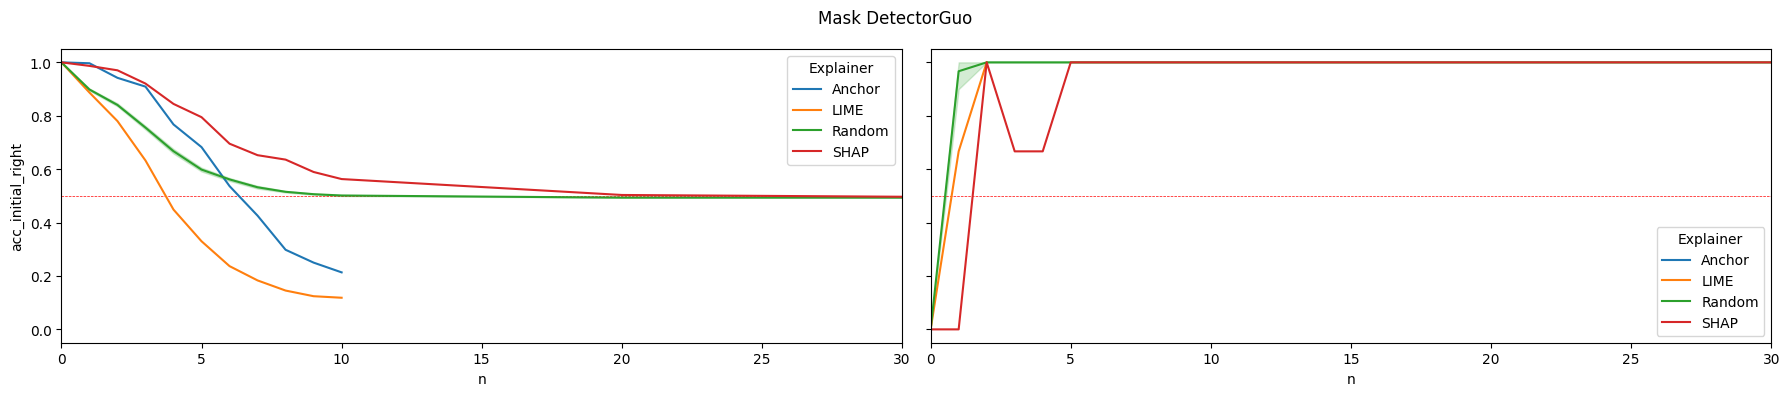

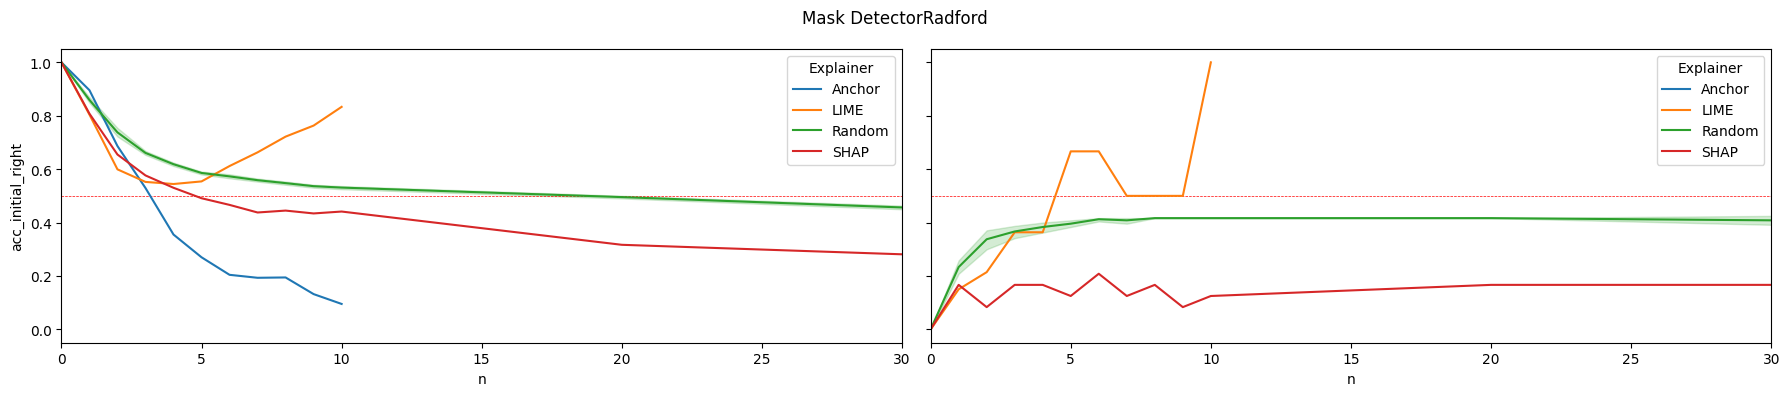

In [20]:
for f in os.listdir(results_path):
    detector_name = f.split(".")[0]
    df_accuracy_scores = pd.read_csv(os.path.join(results_path, f))
    plot_acc(detector_name, df_accuracy_scores, mask=True)

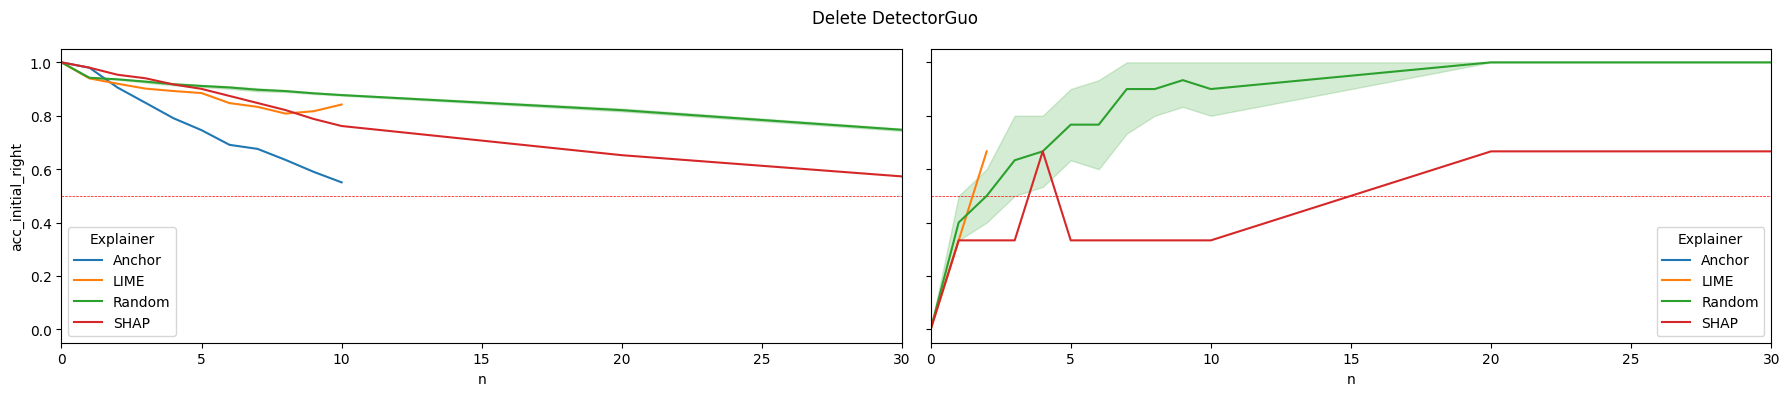

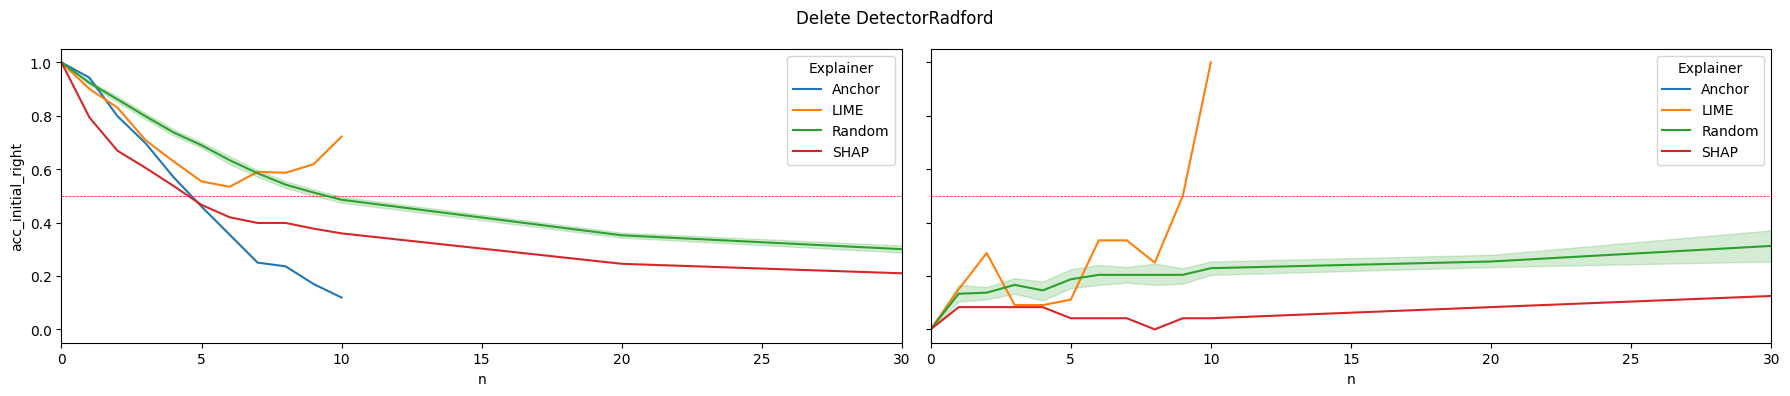

In [21]:
for f in os.listdir(results_path):
    detector_name = f.split(".")[0]
    df_accuracy_scores = pd.read_csv(os.path.join(results_path, f))
    plot_acc(detector_name, df_accuracy_scores, mask=False)

In [22]:
df_accuracy_scores#[df_accuracy_scores["Explainer"] == "Random"]

,Explainer,acc_initial_right,acc_initial_wrong,n,mask,Detector
0,Anchor,1.000000,0.000000,0,True,DetectorRadford
1,LIME,1.000000,0.000000,0,True,DetectorRadford
2,Random,1.000000,0.000000,0,True,DetectorRadford
3,Random,1.000000,0.000000,0,True,DetectorRadford
4,Random,1.000000,0.000000,0,True,DetectorRadford
...,...,...,...,...,...,...
369,Random,0.234875,0.500000,50,False,DetectorRadford
370,Random,0.231317,0.333333,50,False,DetectorRadford
371,Random,0.231317,0.416667,50,False,DetectorRadford
372,Random,0.270463,0.333333,50,False,DetectorRadford


In [28]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",
    'text.usetex': True,
    'pgf.rcfonts': False,
})

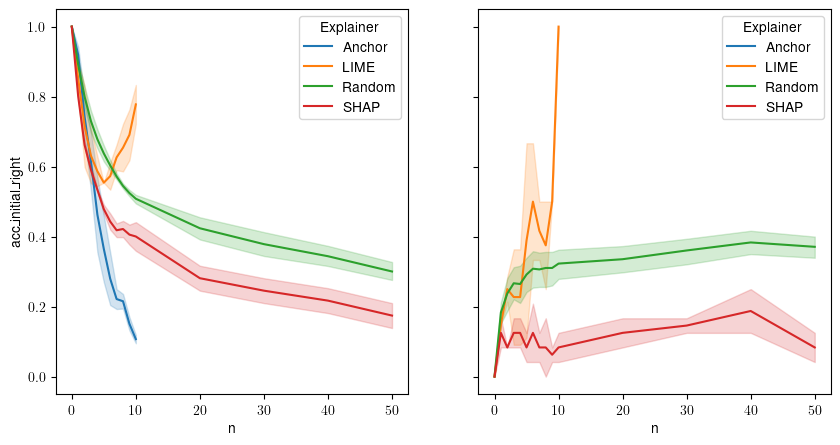

In [29]:
f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)
plt.savefig('./figures/token_removal.pgf')
plt.show()  